# Initialization
using Python 3.11.9, Tensorflow 2.17, Keras 3.5, tf-keras 3.5, keras-core-0.1.7 keras-cv-0.9.0 keras-hub-0.17.0 keras-nlp-0.17.0

In [2]:
!pip install --upgrade pip
!pip uninstall -y tensorflow keras tf-keras
!pip install tensorflow==2.17 keras==3.5 tf-keras==2.17 keras-cv keras-nlp pandas numpy matplotlib seaborn scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [3]:
import time
import numpy as np
import pandas as pd
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras_core.models import Sequential
from keras_core.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Bidirectional, LSTM, MaxPooling1D, Input
from keras_core.preprocessing.sequence import pad_sequences
from keras_core.utils import to_categorical
from keras_core.callbacks import EarlyStopping

Using TensorFlow backend


# Define global functions

In [4]:
# Convert sequences back to text for Naive Bayes
def sequences_to_texts(sequences, word_index):
    reverse_word_index = {v: k for k, v in word_index.items()}
    return [' '.join([reverse_word_index.get(i, '') for i in sequence]) for sequence in sequences]

# Define helper functions for metrics and visualization
def print_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\nMetrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Add class-wise metrics
    class_precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    class_recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    class_f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    print("\nClass-wise metrics:")
    for i, (p, r, f) in enumerate(zip(class_precision, class_recall, class_f1)):
        print(f"Class {i}: Precision: {p:.4f}, Recall: {r:.4f}, F1: {f:.4f}")

    # Print confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # Add class distribution information
    class_distribution = np.sum(cm, axis=1)
    plt.text(1.5, -0.5, f"Class Distribution: {class_distribution}", fontsize=10, ha='right', va='center')

    plt.show()

def plot_roc_curve(y_true, y_pred, model_name, class_labels=['Negative', 'Neutral', 'Positive']):
    # Binarize the output
    classes = np.unique(y_true)
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = y_true_bin.shape[1]

    # Check if y_pred is already probability estimates
    if y_pred.ndim == 1 or y_pred.shape[1] == 1:
        y_pred_bin = label_binarize(y_pred, classes=classes)
        y_score = y_pred_bin
    else:
        y_score = y_pred

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of {class_labels[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

def plot_training_history(history, model_name):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def analyze_predictions(y_true, y_pred, model_name):
    print(f"\nAnalysis for {model_name}:")

    # Class distribution in true labels
    unique, counts = np.unique(y_true, return_counts=True)
    print("Class distribution in true labels:")
    for class_label, count in zip(unique, counts):
        print(f"Class {class_label}: {count}")

    # Class distribution in predictions
    unique, counts = np.unique(y_pred, return_counts=True)
    print("\nClass distribution in predictions:")
    for class_label, count in zip(unique, counts):
        print(f"Class {class_label}: {count}")

    # Check for classes not predicted
    true_classes = set(y_true)
    pred_classes = set(y_pred)
    not_predicted = true_classes - pred_classes
    if not_predicted:
        print(f"\nClasses not predicted by the model: {not_predicted}")

def create_train_test_split(X, y, test_size=0.2, random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Pad sequences
    max_length = 500  # or whatever your max_length is
    X_train_padded = pad_sequences(X_train, maxlen=max_length)
    X_test_padded = pad_sequences(X_test, maxlen=max_length)

    # Convert labels to categorical
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    return X_train_padded, X_test_padded, y_train_cat, y_test_cat, y_train, y_test


# Function to load GloVe embeddings
def load_glove_embeddings(word_index, embedding_dim):
    embeddings_index = {}
    with open(f'glove.6B.{embedding_dim}d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    num_words = min(len(word_index) + 1, 10000)
    embedding_matrix = np.zeros((num_words, embedding_dim))
    for word, i in word_index.items():
        if i >= num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix


# Load our python library

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/phd

Mounted at /content/drive
/content/drive/MyDrive/phd


In [6]:
from bgg import load_data, get_word_index


# Load the data

In [10]:
# Load the full dataset
X, y = load_data(num_words=10000, maxlen=500)
word_index = get_word_index()

num_words = min(10000, len(word_index) + 1)
print(f"Number of words in word_index: {len(word_index)}")
print(f"Number of words in X: {num_words}")
print(f"Shape of X:{X.shape}")
print(f"Shape of y:{y.shape}")
print(f"Unique classes in y: {np.unique(y)}")
print(f"Example of first few labels: {y[:10]}")
# Calculate the length of each sample, excluding padding (assuming padding token is 0)
sample_lengths = np.array([np.sum(x > 0) for x in X])

# Overall statistics
average_word_count = np.mean(sample_lengths)
median_word_count = np.median(sample_lengths)

print(f"Overall average word count per sample: {average_word_count:.2f}")
print(f"Overall median word count per sample: {median_word_count:.2f}")

# Statistics per class
class_labels = np.unique(y)
for label in class_labels:
    class_sample_lengths = sample_lengths[y == label]
    class_avg = np.mean(class_sample_lengths)
    class_median = np.median(class_sample_lengths)
    print(f"\nClass {label} - Average word count: {class_avg:.2f}")
    print(f"Class {label} - Median word count: {class_median:.2f}")


Number of words in word_index: 177257
Number of words in X: 10000
Shape of X:(903916, 500)
Shape of y:(903916,)
Unique classes in y: [0 1 2]
Example of first few labels: [2 1 2 2 2 2 2 2 0 0]
Overall average word count per sample: 21.72
Overall median word count per sample: 14.00

Class 0 - Average word count: 25.35
Class 0 - Median word count: 15.00

Class 1 - Average word count: 23.31
Class 1 - Median word count: 14.00

Class 2 - Average word count: 21.33
Class 2 - Median word count: 14.00


Overall Dataset Sentiment Distribution:


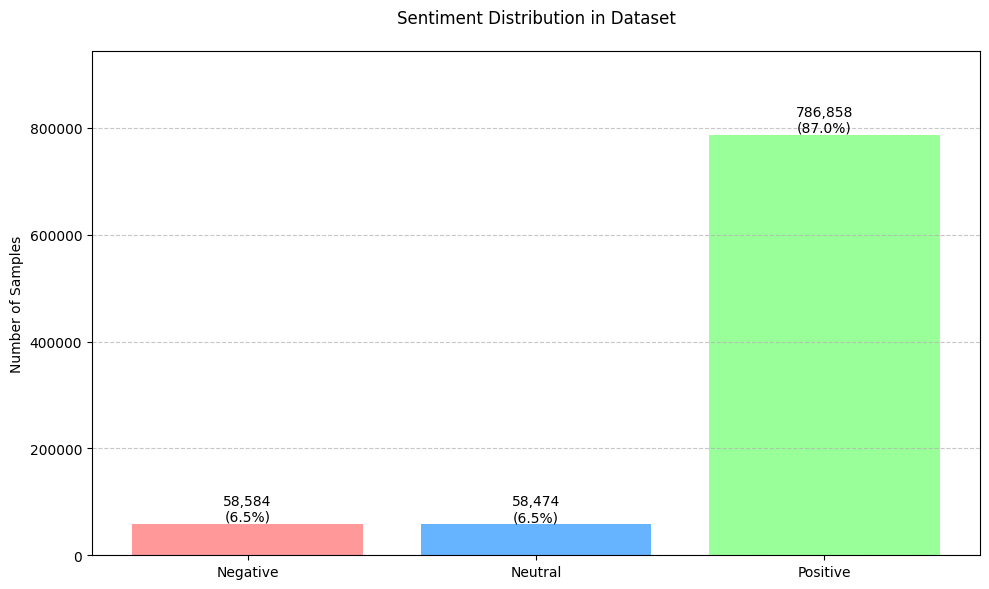


Detailed Sentiment Distribution Statistics:
--------------------------------------------------
Sentiment  Count        Percentage
--------------------------------------------------
Negative   58,584       6.48      %
Neutral    58,474       6.47      %
Positive   786,858      87.05     %
--------------------------------------------------
Total: 903,916 samples

Class Imbalance Metrics:
Imbalance Ratio (Positive:Neutral): 13.46:1
Most frequent sentiment: Positive (786,858 samples)
Least frequent sentiment: Neutral (58,474 samples)


In [7]:
def analyze_sentiment_distribution(y, title="Sentiment Distribution in Dataset"):
    """
    Create a single comprehensive bar chart showing sentiment distribution with both counts and percentages
    """
    # Define sentiment labels
    sentiment_labels = ['Negative', 'Neutral', 'Positive']

    # Calculate distribution
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    class_percentages = (class_counts / total_samples) * 100

    # Create the figure
    plt.figure(figsize=(10, 6))

    # Create bar plot
    colors = ['#ff9999', '#66b3ff', '#99ff99']  # Red, Blue, Green
    bars = plt.bar(sentiment_labels, class_counts, color=colors)

    # Primary y-axis (counts)
    plt.ylabel('Number of Samples', color='black')
    plt.tick_params(axis='y', labelcolor='black')

    # Add count and percentage labels on top of bars
    for bar, count, percentage in zip(bars, class_counts, class_percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count):,}\n({percentage:.1f}%)',
                ha='center', va='bottom')

    # Adjust y-axis limits to prevent cutting off labels
    plt.margins(y=0.2)  # Add 20% padding to the top

    # Customize the plot
    plt.title(title, pad=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print detailed statistics
    print("\nDetailed Sentiment Distribution Statistics:")
    print("-" * 50)
    print(f"{'Sentiment':<10} {'Count':<12} {'Percentage':<10}")
    print("-" * 50)
    for label, count, pct in zip(sentiment_labels, class_counts, class_percentages):
        print(f"{label:<10} {count:<12,} {pct:<10.2f}%")
    print("-" * 50)
    print(f"Total: {total_samples:,} samples")

    # Calculate and print imbalance metrics
    max_count = max(class_counts)
    min_count = min(class_counts)
    imbalance_ratio = max_count / min_count
    majority_sentiment = sentiment_labels[np.argmax(class_counts)]
    minority_sentiment = sentiment_labels[np.argmin(class_counts)]

    print(f"\nClass Imbalance Metrics:")
    print(f"Imbalance Ratio ({majority_sentiment}:{minority_sentiment}): {imbalance_ratio:.2f}:1")
    print(f"Most frequent sentiment: {majority_sentiment} ({max_count:,} samples)")
    print(f"Least frequent sentiment: {minority_sentiment} ({min_count:,} samples)")

# Usage
print("Overall Dataset Sentiment Distribution:")
analyze_sentiment_distribution(y)

# Naive Bayes implementation
This section implements the Naive Bayes model, makes predictions, and generates all the required metrics and visualizations. It uses the helper functions defined in the previous section and NB specific function below for consistency across all models.

In [9]:
# Model Training and Selection
# Test different n-gram ranges to find optimal model configuration.
def evaluate_nb_with_ngrams(X_train, y_train, X_test, y_test, ngram_range):
    # Start total pipeline timer
    total_start_time = time.time()

    # Time vectorization
    vectorization_start = time.time()
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)
    vectorization_time = time.time() - vectorization_start

    training_start = time.time()
    nb_model = MultinomialNB()
    nb_model.fit(X_train_vectorized, y_train)
    training_time = time.time() - training_start

    prediction_start = time.time()
    y_pred = nb_model.predict(X_test_vectorized)
    prediction_time = time.time() - prediction_start
    accuracy = accuracy_score(y_test, y_pred)

    total_time = time.time() - total_start_time


    print(f"N-gram range: {ngram_range}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Vectorization Time: {vectorization_time:.2f} seconds")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Prediction Time: {prediction_time:.2f} seconds")
    print(f"Total Pipeline Time: {total_time:.2f} seconds")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("-" * 50)

    return nb_model, vectorizer, y_pred, nb_model.predict_proba(X_test_vectorized), training_time, prediction_time, total_time

# Results Visualization and Analysis
def create_nb_model_summary_figure(model):
    print("Model Summary\n\n"
             f"Naive Bayes Model Details:\n{str(model)}\n\n"
             f"Model Parameters:\n{str(model.__dict__)}")

def create_nb_confusion_matrix_figure(y_test, y_pred):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Neutral', 'Positive'],
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(f'NB_confusion_matrix.png')
    plt.show()

def create_nb_classification_report_figure(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    report = classification_report(y_test, y_pred, digits=4)
    plt.text(0.1, 0.9,
             f"Classification Report\n\n{report}",
             fontsize=10, family='monospace', verticalalignment='top')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'NB_classification_report.png')
    plt.show()



## Data preparation for the NB model

In [10]:
def sequences_to_text(sequences, word_index):
    reverse_word_index = {v: k for k, v in word_index.items()}
    return [' '.join([reverse_word_index.get(i, '') for i in sequence if i != 0]) for sequence in sequences]

# Create split for Naive Bayes
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_nb_text = sequences_to_text(X_train_nb, word_index)
X_test_nb_text = sequences_to_text(X_test_nb, word_index)

##Run the NB Model

N-gram range: (1, 1)
Accuracy: 0.8566
Vectorization Time: 15.56 seconds
Training Time: 0.13 seconds
Prediction Time: 0.04 seconds
Total Pipeline Time: 15.73 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.33      0.36     14574
           1       0.22      0.11      0.15     14556
           2       0.91      0.95      0.93    196849

    accuracy                           0.86    225979
   macro avg       0.51      0.46      0.48    225979
weighted avg       0.83      0.86      0.84    225979

--------------------------------------------------
N-gram range: (1, 2)
Accuracy: 0.8753
Vectorization Time: 43.69 seconds
Training Time: 0.60 seconds
Prediction Time: 0.14 seconds
Total Pipeline Time: 44.43 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.08      0.14     14574
           1       0.44      0.01      0.01     14556
           2       0.88    

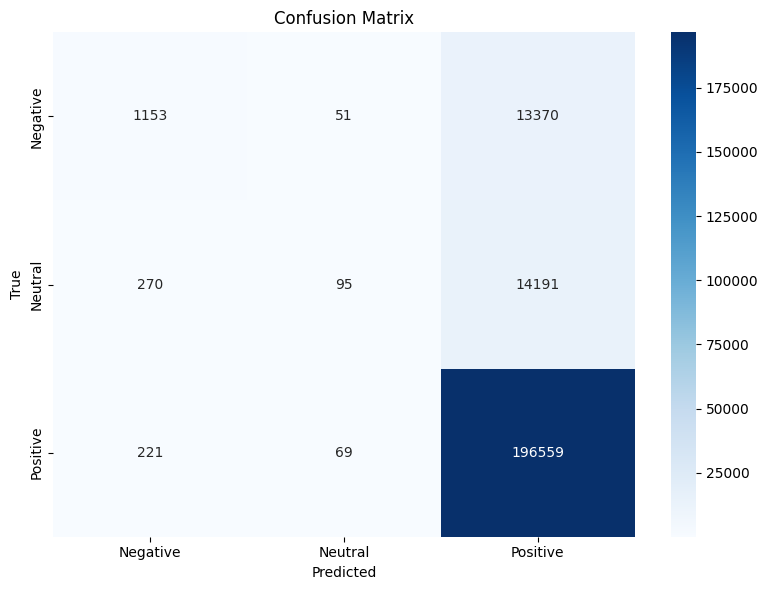

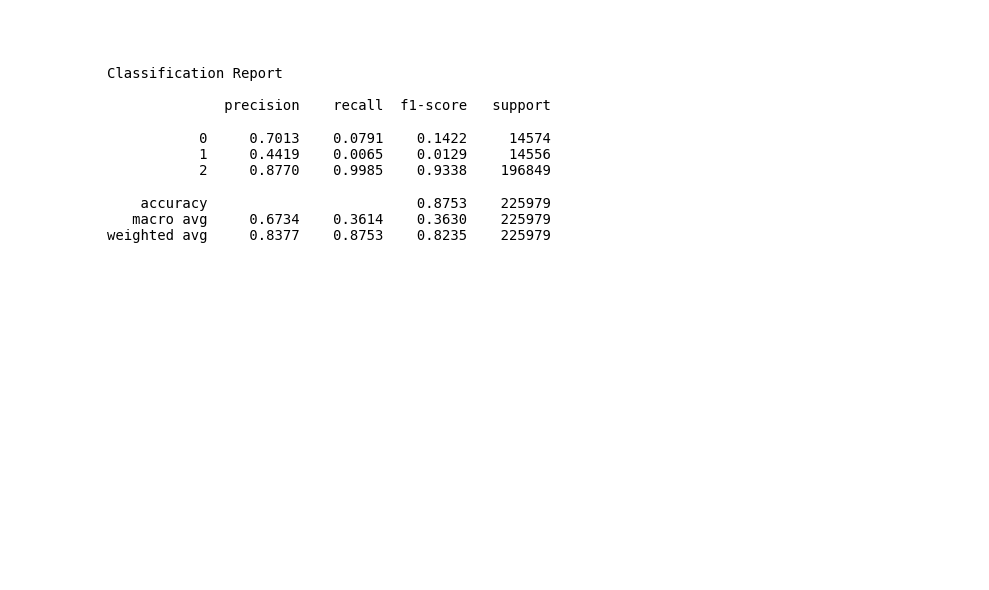

Best n-gram range: (1, 2)
Best Model Accuracy: 0.8753
Training Time: 0.60 seconds
Prediction Time: 0.14 seconds
Pipeline Time: 44.43 seconds


In [11]:
# Test different n-gram ranges
ngram_ranges = [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)]
best_model, best_accuracy = None, 0
for ngram_range in ngram_ranges:
    model, vectorizer, predictions, probabilities, train_time, prediction_time, pipeline_time = evaluate_nb_with_ngrams(
        X_train_nb_text, y_train_nb, X_test_nb_text, y_test_nb, ngram_range
    )
    accuracy = accuracy_score(y_test_nb, predictions)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_vectorizer = vectorizer
        best_predictions = predictions
        best_probabilities = probabilities
        best_train_time = train_time
        best_prediction_time = prediction_time
        best_pipeline_time = pipeline_time
        best_ngram_range = ngram_range

# Generate and display results
create_nb_model_summary_figure(best_model)
create_nb_confusion_matrix_figure(y_test_nb, best_predictions)
create_nb_classification_report_figure(y_test_nb, best_predictions)

# Store Results for Comparison
nb_results_dict = {
    'model': best_model,
    'accuracy': best_accuracy,
    'train_time': best_train_time,
    'prediction_time': best_prediction_time,
    'pipeline_time': best_pipeline_time,
    'y_true': y_test_nb,
    'y_pred': best_predictions,
    'y_pred_proba': best_probabilities
}

print(f"Best n-gram range: {best_ngram_range}")
print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Training Time: {best_train_time:.2f} seconds")
print(f"Prediction Time: {best_prediction_time:.2f} seconds")
print(f"Pipeline Time: {best_pipeline_time:.2f} seconds")

# CNN
This section defines, trains, and evaluates the CNN model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.

In [12]:
def create_and_train_cnn(embedding_dim, num_words, max_length, X_train, y_train, X_test, y_test, embedding_matrix):

    start_pipeline_time = time.time()
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    model_start = time.time()
    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Conv1D(128, 5, activation='relu', name='conv1d'),
        GlobalMaxPooling1D(name='global_max_pooling1d'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    # Set the embedding weights after layer creation
    model.get_layer('embedding').set_weights([embedding_matrix])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_time = time.time() - model_start


    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    train_time = time.time() - start_time

    pipeline_time = time.time() - start_pipeline_time

    return model, history, train_time, model_time, pipeline_time

def compare_cnn_variations(cnn_results):
    cnn_df = pd.DataFrame(cnn_results, columns=['Embedding Dim', 'Accuracy', 'F1-Score', 'AUC-ROC', 'Training Time'])
    # Replace infinity values with NaN
    cnn_df = cnn_df.replace([np.inf, -np.inf], np.nan)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=cnn_df, x='Embedding Dim', y='Accuracy', marker='o', label='Accuracy')
    sns.lineplot(data=cnn_df, x='Embedding Dim', y='F1-Score', marker='s', label='F1-Score')
    plt.title('CNN Performance across Embedding Dimensions')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    # Print results
    print("CNN Variation Results:")
    print(cnn_df.to_string(index=False))

    # Determine best configuration
    best_cnn = cnn_df.loc[cnn_df['Accuracy'].idxmax()]
    print(f"\nBest CNN Configuration: Embedding Dim = {best_cnn['Embedding Dim']}")
    print(f"Best Accuracy: {best_cnn['Accuracy']:.4f}")
    print(f"Best F1-Score: {best_cnn['F1-Score']:.4f}")


## Data preparation

In [13]:
# Create a specific split for CNN
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

# Pad sequences
max_length = 500
X_train_cnn_padded = pad_sequences(X_train_cnn, maxlen=max_length)
X_test_cnn_padded = pad_sequences(X_test_cnn, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_cnn))
y_train_cnn_cat = to_categorical(y_train_cnn, num_classes=num_classes)
y_test_cnn_cat = to_categorical(y_test_cnn, num_classes=num_classes)

## Test the variations of the CNN model


Training CNN with embedding dimension: 100
Epoch 1/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step - accuracy: 0.8728 - loss: 0.4150 - val_accuracy: 0.8787 - val_loss: 0.3654
Epoch 2/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.8797 - loss: 0.3651 - val_accuracy: 0.8818 - val_loss: 0.3570
Epoch 3/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.8842 - loss: 0.3439 - val_accuracy: 0.8821 - val_loss: 0.3607
Epoch 4/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.8866 - loss: 0.3277 - val_accuracy: 0.8817 - val_loss: 0.3680
Epoch 5/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.8902 - loss: 0.3092 - val_accuracy: 0.8780 - val_loss: 0.3747
Test Accuracy: 0.8780
5650/5650 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step

Training CNN with embedding dimension: 200
Epoch 1/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step - accuracy: 0.8718 - loss: 0.4138 - val_accuracy: 0.8790 - val_loss: 0.3645
Epoch 2/5
22598/22598 ━━━━━━━━━━━━━━━━━━━━ 53s 2ms/step

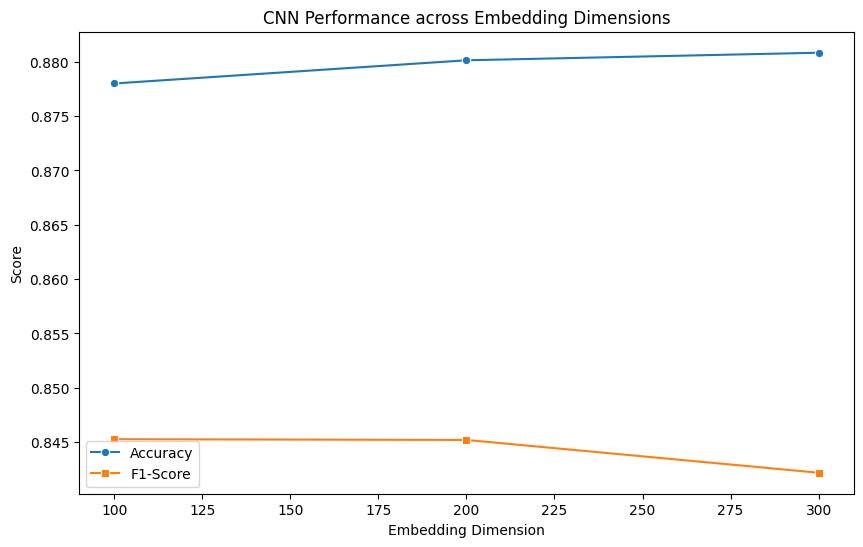

CNN Variation Results:
 Embedding Dim  Accuracy  F1-Score  AUC-ROC  Training Time
           100  0.878009  0.845265 0.847046     260.498512
           200  0.880144  0.845197 0.841935     266.186370
           300  0.880841  0.842180 0.835068     292.934750

Best CNN Configuration: Embedding Dim = 300.0
Best Accuracy: 0.8808
Best F1-Score: 0.8422

Best embedding dimension: 300
Best Accuracy: 0.8808
5650/5650 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step

Metrics for CNN (Embedding Dim: 300):
Accuracy: 0.8808
Precision: 0.8127
Recall: 0.8808
F1 Score: 0.8422

Class-wise metrics:
Class 0: Precision: 0.5399, Recall: 0.2900, F1: 0.3773
Class 1: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 2: Precision: 0.8930, Recall: 0.9898, F1: 0.9389

Confusion Matrix:
[[  3374      0   8262]
 [  1261      0  10405]
 [  1614      0 155868]]


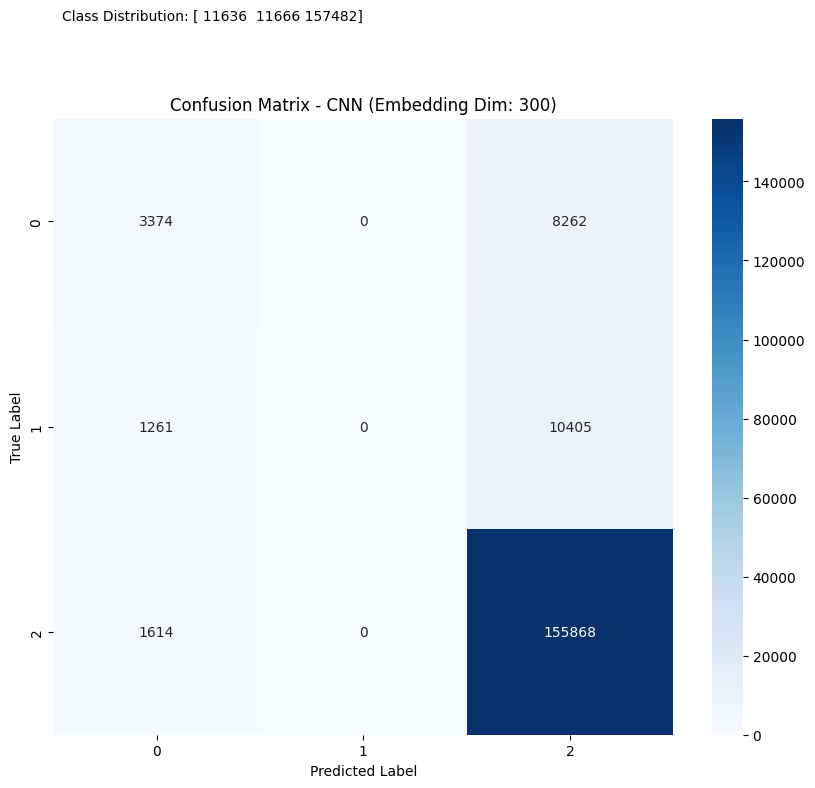

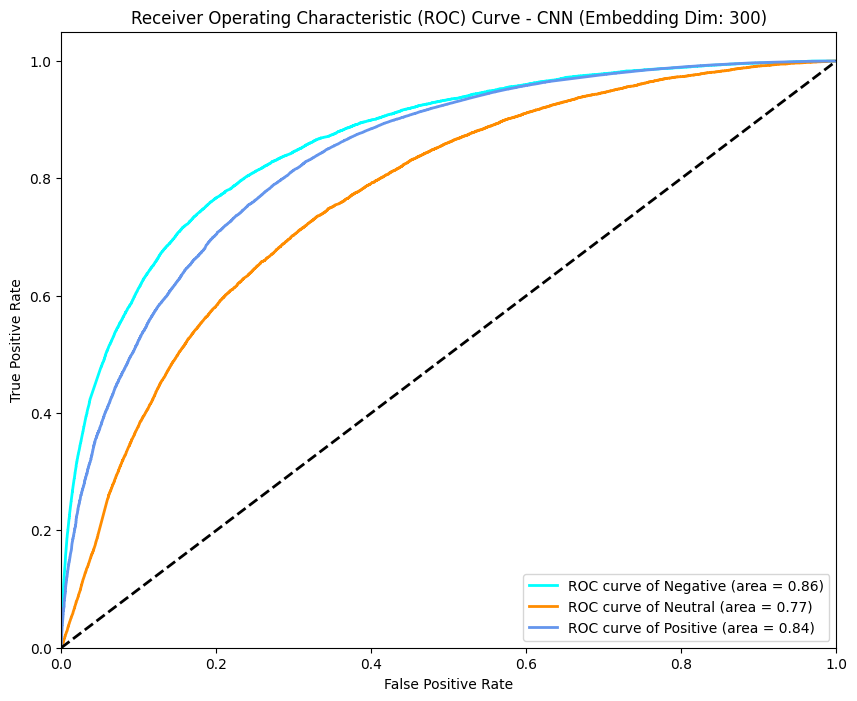


Classification Report - CNN (Embedding Dim: 300):
              precision    recall  f1-score   support

           0       0.54      0.29      0.38     11636
           1       0.00      0.00      0.00     11666
           2       0.89      0.99      0.94    157482

    accuracy                           0.88    180784
   macro avg       0.48      0.43      0.44    180784
weighted avg       0.81      0.88      0.84    180784



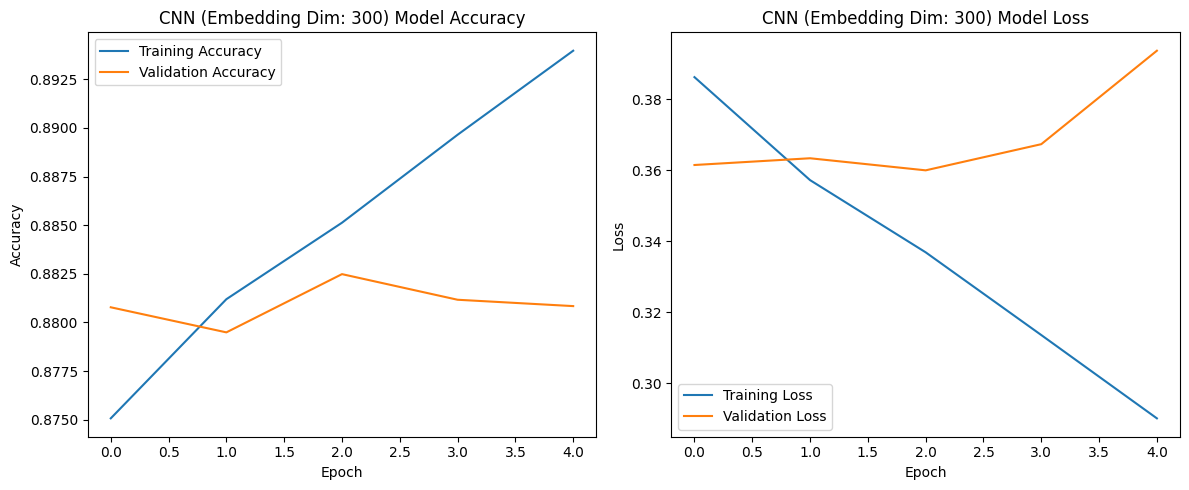


Analysis for CNN (Embedding Dim: 300):
Class distribution in true labels:
Class 0: 11636
Class 1: 11666
Class 2: 157482

Class distribution in predictions:
Class 0: 6249
Class 2: 174535

Classes not predicted by the model: {1}
Model Summary


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ (None, 500, 300)              │   3,000,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv1d (Conv1D)                    │ (None, 496, 128)              │     192,128 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ global_max_pooling1d               │ (None, 128)                   │           0 │
│ (GlobalMaxPooling1D)               │                               │             │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 10)                    │       1,290 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 10)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ output (Dense)                     │ (None, 3)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 9,580,355 (36.55 MB)

 Trainable params: 3,193,451 (12.18 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,386,904 (24.36 MB)

Best Model Accuracy: 0.8808
Training Time: 292.93 seconds
Prediction Time: 8.55 seconds
Pipeline Time: 292.98 seconds


In [14]:
# Test different embedding dimensions
embedding_dims = [100, 200, 300]
num_words = min(10000, len(word_index) + 1)  # Assuming word_index is defined

best_model = None
best_accuracy = 0
best_history = None
best_dim = None

cnn_results = []

for dim in embedding_dims:
    print(f"\nTraining CNN with embedding dimension: {dim}")

    # Load GloVe embeddings for the current dimension
    embedding_matrix = load_glove_embeddings(word_index, dim)

    model, history, train_time, model_time, pipeline_time = create_and_train_cnn(dim, num_words, max_length, X_train_cnn_padded, y_train_cnn_cat, X_test_cnn_padded, y_test_cnn_cat, embedding_matrix)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_cnn_padded, y_test_cnn_cat, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate F1-Score
    y_pred = model.predict(X_test_cnn_padded)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test_cnn_cat, axis=1)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(y_test_cnn_cat, y_pred, multi_class='ovr', average='weighted')

    # Record results
    cnn_results.append([dim, accuracy, f1, auc_roc, train_time])

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_history = history
        best_dim = dim
        best_train_time = train_time
        best_model_time = model_time
        best_pipeline_time = pipeline_time

# Compare CNN variations
compare_cnn_variations(cnn_results)

print(f"\nBest embedding dimension: {best_dim}")
print(f"Best Accuracy: {best_accuracy:.4f}")

# Use the best model for further analysis
cnn_model = best_model
history_cnn = best_history

# Make predictions using the best model
prediction_start = time.time()
y_pred_cnn = cnn_model.predict(X_test_cnn_padded)
best_prediction_time = time.time() - prediction_start
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

# Print metrics
print_metrics(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Plot confusion matrix
plot_confusion_matrix(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Plot ROC curve
plot_roc_curve(y_test_cnn, y_pred_cnn, f"CNN (Embedding Dim: {best_dim})")

# Print classification report
print(f"\nClassification Report - CNN (Embedding Dim: {best_dim}):")
print(classification_report(y_test_cnn, y_pred_classes_cnn, zero_division=0))

# Plot training history
plot_training_history(history_cnn, f"CNN (Embedding Dim: {best_dim})")

# Analyze predictions
analyze_predictions(y_test_cnn, y_pred_classes_cnn, f"CNN (Embedding Dim: {best_dim})")

# Store results for later comparison
cnn_results_dict = {
    'model': best_model,
    'embedding_dim': best_dim,
    'accuracy': best_accuracy,
    'train_time': best_train_time,
    'prediction_time': best_prediction_time,
    'pipeline_time': best_pipeline_time,
    'model_time': best_model_time,
    'y_true': y_test_cnn,
    'y_pred': y_pred_classes_cnn,
    'y_pred_proba': y_pred_cnn
}
# Present results for best model only
print("Model Summary")
best_model.summary()

print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Training Time: {best_train_time:.2f} seconds")
print(f"Prediction Time: {best_prediction_time:.2f} seconds")
print(f"Pipeline Time: {best_pipeline_time:.2f} seconds")

# BiLSTM
This section defines, trains, and evaluates the BiLSTM model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.


In [19]:
# Function to create and train BiLSTM model
def create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units, X_train, y_train, X_test, y_test, embedding_matrix):

    pipeline_start = time.time()
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    model_start = time.time()
    model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_1'),
        Bidirectional(LSTM(lstm_units // 2), name='bilstm_2'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    # Set the embedding weights after layer creation
    model.get_layer('embedding').set_weights([embedding_matrix])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_time = time.time() - model_start

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model and measure training time
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
    train_time = time.time() - start_time

    pipeline_time = time.time() - pipeline_start

    return model, history, train_time, model_time, pipeline_time

def compare_bilstm_variations(bilstm_results):
    bilstm_df = pd.DataFrame(bilstm_results, columns=['LSTM Units', 'Accuracy', 'F1-Score', 'AUC-ROC', 'Training Time'])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=bilstm_df, x='LSTM Units', y='Accuracy', marker='o', label='Accuracy')
    sns.lineplot(data=bilstm_df, x='LSTM Units', y='F1-Score', marker='s', label='F1-Score')
    plt.title('BiLSTM Performance across LSTM Units')
    plt.xlabel('LSTM Units')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

    # Print results
    print("BiLSTM Variation Results:")
    print(bilstm_df.to_string(index=False))

    # Determine best configuration
    best_bilstm = bilstm_df.loc[bilstm_df['Accuracy'].idxmax()]
    print(f"\nBest BiLSTM Configuration: LSTM Units = {best_bilstm['LSTM Units']}")
    print(f"Best Accuracy: {best_bilstm['Accuracy']:.4f}")
    print(f"Best F1-Score: {best_bilstm['F1-Score']:.4f}")
    print(f"Training time for best configuration: {best_bilstm['Training Time']:.4f}")


# Common setup (move this outside the loop)
X_train_bilstm, X_test_bilstm, y_train_bilstm, y_test_bilstm = train_test_split(X, y, test_size=0.25, random_state=42)

# Pad sequences
max_length = 500
X_train_bilstm_padded = pad_sequences(X_train_bilstm, maxlen=max_length)
X_test_bilstm_padded = pad_sequences(X_test_bilstm, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_bilstm))
y_train_bilstm_cat = to_categorical(y_train_bilstm, num_classes=num_classes)
y_test_bilstm_cat = to_categorical(y_test_bilstm, num_classes=num_classes)

embedding_dim = best_dim  # Set to best performing from CNN model
num_words = min(10000, len(word_index) + 1)

# Load GloVe embeddings
print(f"\nLoading best embeddings dimensions as found by CNN: {embedding_dim}")
embedding_matrix = load_glove_embeddings(word_index, embedding_dim)

# Initialize variables to track best model
best_model = None
best_accuracy = 0
best_history = None
best_units = None
best_train_time = 0
bilstm_results = []




Loading best embeddings dimensions as found by CNN: 300


In [20]:
# First iteration: 64 LSTM units
lstm_units = 64
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_64, history_64, train_time_64, model_time_64, pipeline_time_64 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                              X_train_bilstm_padded, y_train_bilstm_cat,
                                                              X_test_bilstm_padded, y_test_bilstm_cat,
                                                              embedding_matrix)

# Evaluate the model
loss_64, accuracy_64 = model_64.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_64:.4f}")

# Calculate F1-Score
y_pred_64 = model_64.predict(X_test_bilstm_padded)
y_pred_classes_64 = np.argmax(y_pred_64, axis=1)
y_true_classes = np.argmax(y_test_bilstm_cat, axis=1)
f1_64 = f1_score(y_true_classes, y_pred_classes_64, average='weighted')

# Calculate AUC-ROC
auc_roc_64 = roc_auc_score(y_test_bilstm_cat, y_pred_64, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_64, f1_64, auc_roc_64, train_time_64])

# Update best model if needed
if accuracy_64 > best_accuracy:
    best_accuracy = accuracy_64
    best_model = model_64
    best_history = history_64
    best_units = lstm_units
    best_train_time = train_time_64
    best_model_time = model_time_64
    best_pipeline_time = pipeline_time_64


Training BiLSTM with 64 LSTM units
Epoch 1/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1438s 68ms/step - accuracy: 0.8738 - loss: 0.4024 - val_accuracy: 0.8827 - val_loss: 0.3544
Epoch 2/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1433s 68ms/step - accuracy: 0.8819 - loss: 0.3502 - val_accuracy: 0.8836 - val_loss: 0.3491
Epoch 3/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1431s 68ms/step - accuracy: 0.8857 - loss: 0.3334 - val_accuracy: 0.8833 - val_loss: 0.3516
Epoch 4/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1433s 68ms/step - accuracy: 0.8892 - loss: 0.3194 - val_accuracy: 0.8825 - val_loss: 0.3549
Epoch 5/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1432s 68ms/step - accuracy: 0.8926 - loss: 0.3052 - val_accuracy: 0.8816 - val_loss: 0.3606
Test Accuracy: 0.8836
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 174s 25ms/step


In [21]:
# Second iteration: 128 LSTM units
lstm_units = 128
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_128, history_128, train_time_128, model_time_128, pipeline_time_128 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                                 X_train_bilstm_padded, y_train_bilstm_cat,
                                                                 X_test_bilstm_padded, y_test_bilstm_cat,
                                                                 embedding_matrix)

# Evaluate the model
loss_128, accuracy_128 = model_128.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_128:.4f}")

# Calculate F1-Score
y_pred_128 = model_128.predict(X_test_bilstm_padded)
y_pred_classes_128 = np.argmax(y_pred_128, axis=1)
f1_128 = f1_score(y_true_classes, y_pred_classes_128, average='weighted')

# Calculate AUC-ROC
auc_roc_128 = roc_auc_score(y_test_bilstm_cat, y_pred_128, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_128, f1_128, auc_roc_128, train_time_128])

# Update best model if needed
if accuracy_128 > best_accuracy:
    best_accuracy = accuracy_128
    best_model = model_128
    best_history = history_128
    best_units = lstm_units
    best_train_time = train_time_128
    best_model_time = model_time_128
    best_pipeline_time = pipeline_time_128


Training BiLSTM with 128 LSTM units
Epoch 1/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1498s 71ms/step - accuracy: 0.8753 - loss: 0.3966 - val_accuracy: 0.8820 - val_loss: 0.3566
Epoch 2/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1497s 71ms/step - accuracy: 0.8826 - loss: 0.3488 - val_accuracy: 0.8829 - val_loss: 0.3513
Epoch 3/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1496s 71ms/step - accuracy: 0.8861 - loss: 0.3327 - val_accuracy: 0.8836 - val_loss: 0.3507
Epoch 4/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1498s 71ms/step - accuracy: 0.8888 - loss: 0.3200 - val_accuracy: 0.8834 - val_loss: 0.3540
Epoch 5/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1498s 71ms/step - accuracy: 0.8915 - loss: 0.3063 - val_accuracy: 0.8821 - val_loss: 0.3591
Test Accuracy: 0.8821
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 172s 24ms/step


In [22]:
# Third iteration: 256 LSTM units
lstm_units = 256
print(f"\nTraining BiLSTM with {lstm_units} LSTM units")

model_256, history_256, train_time_256, model_time_256, pipeline_time_256 = create_and_train_bilstm(embedding_dim, num_words, max_length, lstm_units,
                                                                 X_train_bilstm_padded, y_train_bilstm_cat,
                                                                 X_test_bilstm_padded, y_test_bilstm_cat,
                                                                 embedding_matrix)

# Evaluate the model
loss_256, accuracy_256 = model_256.evaluate(X_test_bilstm_padded, y_test_bilstm_cat, verbose=0)
print(f"Test Accuracy: {accuracy_256:.4f}")

# Calculate F1-Score
y_pred_256 = model_256.predict(X_test_bilstm_padded)
y_pred_classes_256 = np.argmax(y_pred_256, axis=1)
f1_256 = f1_score(y_true_classes, y_pred_classes_256, average='weighted')

# Calculate AUC-ROC
auc_roc_256 = roc_auc_score(y_test_bilstm_cat, y_pred_256, multi_class='ovr', average='weighted')

# Record results
bilstm_results.append([lstm_units, accuracy_256, f1_256, auc_roc_256, train_time_256])

# Update best model if needed
if accuracy_256 > best_accuracy:
    best_accuracy = accuracy_256
    best_model = model_256
    best_history = history_256
    best_units = lstm_units
    best_train_time = train_time_256
    best_model_time = model_time_256
    best_pipeline_time = pipeline_time_256


Training BiLSTM with 256 LSTM units
Epoch 1/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1517s 71ms/step - accuracy: 0.8739 - loss: 0.4101 - val_accuracy: 0.8813 - val_loss: 0.3619
Epoch 2/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1511s 71ms/step - accuracy: 0.8808 - loss: 0.3607 - val_accuracy: 0.8828 - val_loss: 0.3562
Epoch 3/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1511s 71ms/step - accuracy: 0.8832 - loss: 0.3471 - val_accuracy: 0.8828 - val_loss: 0.3539
Epoch 4/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1511s 71ms/step - accuracy: 0.8846 - loss: 0.3402 - val_accuracy: 0.8831 - val_loss: 0.3520
Epoch 5/5
21186/21186 ━━━━━━━━━━━━━━━━━━━━ 1510s 71ms/step - accuracy: 0.8874 - loss: 0.3287 - val_accuracy: 0.8833 - val_loss: 0.3539
Test Accuracy: 0.8833
7062/7062 ━━━━━━━━━━━━━━━━━━━━ 178s 25ms/step



Best number of LSTM units: 64
Best Accuracy: 0.8836
Train time for best configuration: 7167.561931848526
Model time for best configuration: 0.0991981029510498
Pipeline time for best configuration: 7167.661148309708
Best model summary:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ embedding (Embedding)              │ (None, 500, 300)              │   3,000,000 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bilstm_1 (Bidirectional)           │ (None, 500, 128)              │     186,880 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bilstm_2 (Bidirectional)           │ (None, 64)                    │      41,216 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 10)                    │         650 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 10)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ output (Dense)                     │ (None, 3)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 9,686,339 (36.95 MB)

 Trainable params: 3,228,779 (12.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,457,560 (24.63 MB)

7062/7062 ━━━━━━━━━━━━━━━━━━━━ 173s 24ms/step

Metrics for BiLSTM (64 units):
Accuracy: 0.8836
Precision: 0.8166
Recall: 0.8836
F1 Score: 0.8459

Class-wise metrics:
Class 0: Precision: 0.5627, Recall: 0.3207, F1: 0.4086
Class 1: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 2: Precision: 0.8958, Recall: 0.9906, F1: 0.9408

Confusion Matrix:
[[  4674      0   9900]
 [  1776      0  12780]
 [  1856      0 194993]]


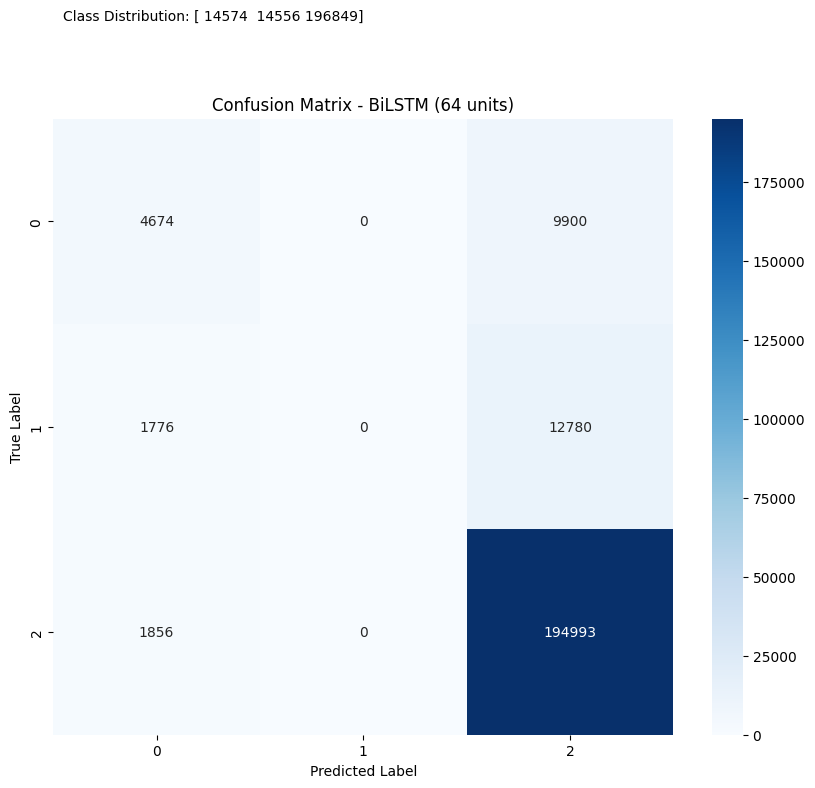

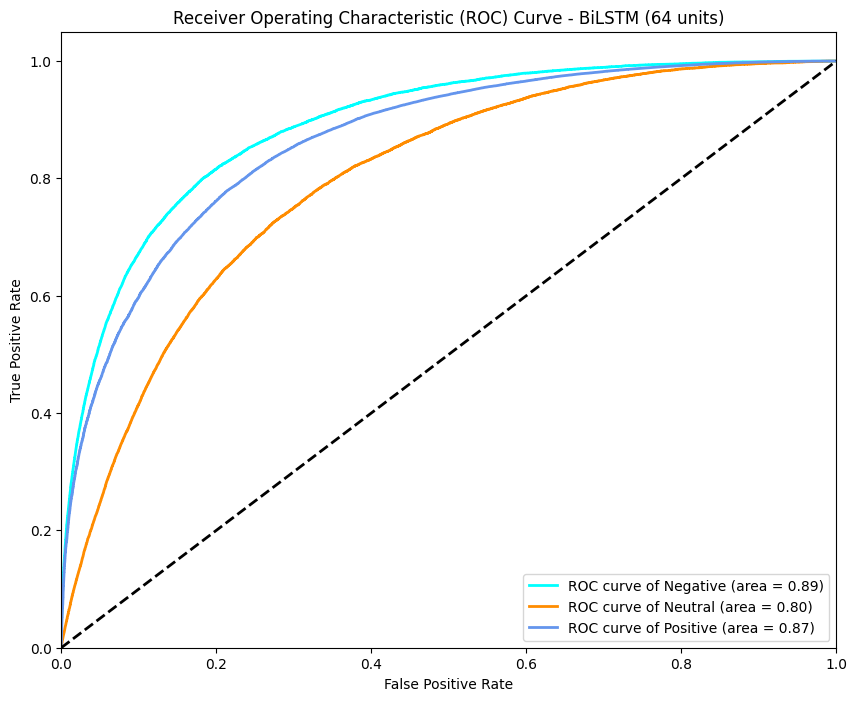


Classification Report - BiLSTM (64 units):
              precision    recall  f1-score   support

           0       0.56      0.32      0.41     14574
           1       0.00      0.00      0.00     14556
           2       0.90      0.99      0.94    196849

    accuracy                           0.88    225979
   macro avg       0.49      0.44      0.45    225979
weighted avg       0.82      0.88      0.85    225979



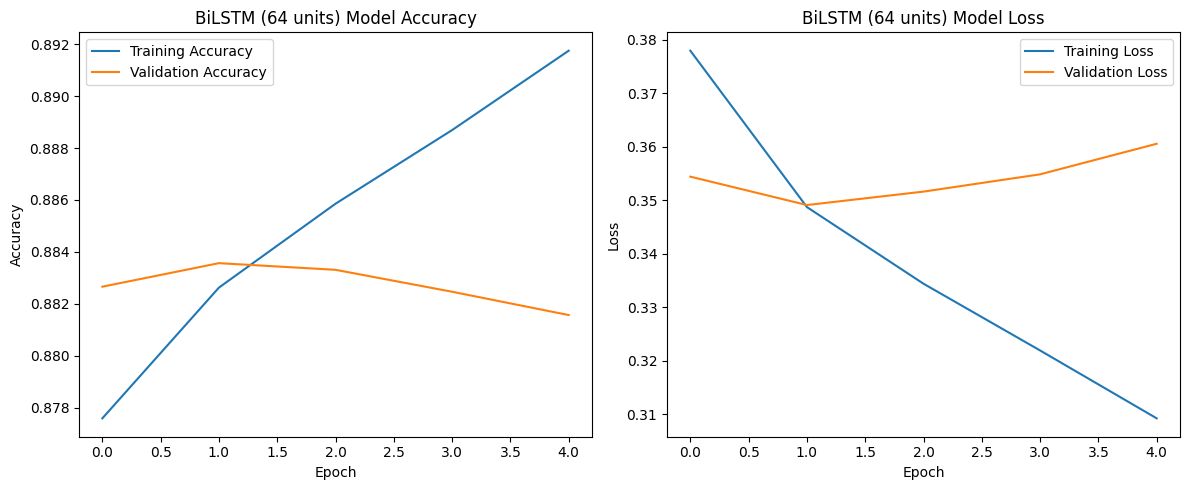


Analysis for BiLSTM (64 units):
Class distribution in true labels:
Class 0: 14574
Class 1: 14556
Class 2: 196849

Class distribution in predictions:
Class 0: 8306
Class 2: 217673

Classes not predicted by the model: {1}


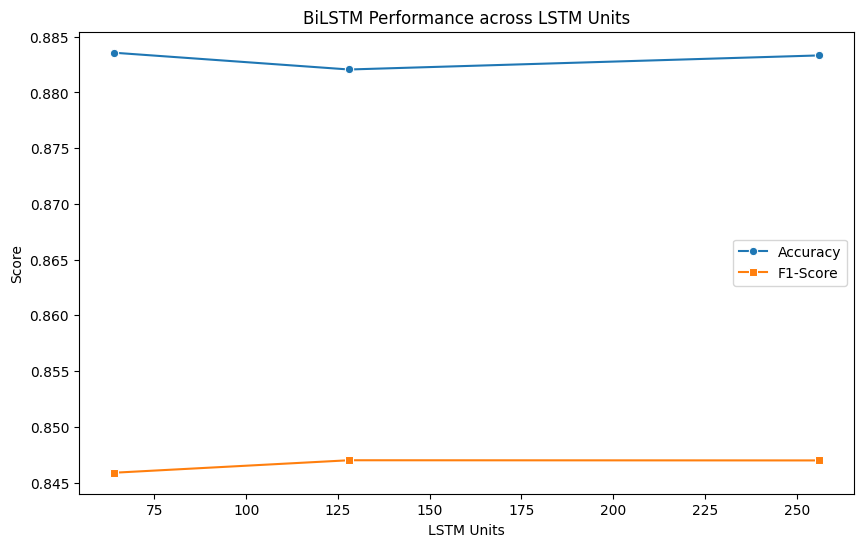

BiLSTM Variation Results:
 LSTM Units  Accuracy  F1-Score  AUC-ROC  Training Time
         64  0.883564  0.845883 0.862171    7167.561932
        128  0.882060  0.847002 0.856441    7487.055396
        256  0.883321  0.846986 0.859398    7560.189121

Best BiLSTM Configuration: LSTM Units = 64.0
Best Accuracy: 0.8836
Best F1-Score: 0.8459
Training time for best configuration: 7167.5619


In [23]:
print(f"\nBest number of LSTM units: {best_units}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Train time for best configuration: {best_train_time}")
print(f"Model time for best configuration: {best_model_time}")
print(f"Pipeline time for best configuration: {best_pipeline_time}")
print(f"Best model summary:")
best_model.summary()

# Use the best model for further analysis
bilstm_model = best_model
history_bilstm = best_history

# Make predictions using the best model
prediction_start = time.time()
y_pred_bilstm = bilstm_model.predict(X_test_bilstm_padded)
best_prediction_time = time.time() - prediction_start
y_pred_classes_bilstm = np.argmax(y_pred_bilstm, axis=1)

# Print metrics
print_metrics(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Plot confusion matrix
plot_confusion_matrix(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Plot ROC curve
plot_roc_curve(y_test_bilstm, y_pred_bilstm, f"BiLSTM ({best_units} units)")

# Print classification report
print(f"\nClassification Report - BiLSTM ({best_units} units):")
print(classification_report(y_test_bilstm, y_pred_classes_bilstm, zero_division=0))

# Plot training history
plot_training_history(history_bilstm, f"BiLSTM ({best_units} units)")

# Analyze predictions
analyze_predictions(y_test_bilstm, y_pred_classes_bilstm, f"BiLSTM ({best_units} units)")

# Store results for later comparison
bilstm_results_dict = {
    'model': bilstm_model,
    'lstm_units': best_units,
    'accuracy': best_accuracy,
    'y_true': y_test_bilstm,
    'y_pred': y_pred_classes_bilstm,
    'y_pred_proba': y_pred_bilstm,
    'train_time': best_train_time,
    'model_time': best_model_time,
    'pipeline_time': best_pipeline_time,
    'prediction_time': best_prediction_time
}

# Compare BiLSTM variations
compare_bilstm_variations(bilstm_results)

# Hybrid CNN-BiLSTM
This section defines, trains, and evaluates the hybrid CNN-BiLSTM model. It includes all the necessary metrics and visualizations, using the helper functions defined earlier.


Training Hybrid CNN-BiLSTM with 64 LSTM units and 300-dimensional embeddings
Epoch 1/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 487s 24ms/step - accuracy: 0.8739 - loss: 0.4052 - val_accuracy: 0.8813 - val_loss: 0.3600
Epoch 2/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 481s 24ms/step - accuracy: 0.8802 - loss: 0.3564 - val_accuracy: 0.8820 - val_loss: 0.3563
Epoch 3/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 481s 24ms/step - accuracy: 0.8845 - loss: 0.3387 - val_accuracy: 0.8816 - val_loss: 0.3589
Epoch 4/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 481s 24ms/step - accuracy: 0.8894 - loss: 0.3209 - val_accuracy: 0.8812 - val_loss: 0.3620
Epoch 5/5
19774/19774 ━━━━━━━━━━━━━━━━━━━━ 480s 24ms/step - accuracy: 0.8930 - loss: 0.3050 - val_accuracy: 0.8797 - val_loss: 0.3703
Test Accuracy: 0.8797
8475/8475 ━━━━━━━━━━━━━━━━━━━━ 65s 8ms/step

Hybrid CNN-BiLSTM Results:
Embedding Dimensions: 300
LSTM Units: 64
Accuracy: 0.8797
F1-Score: 0.8462
AUC-ROC: 0.8492
Training Time: 2409.79 seconds
Model Time: 0.10 seconds
Pipeline Ti

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)         │ (None, 124, 128)              │   3,192,128 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bilstm_1 (Bidirectional)           │ (None, 124, 128)              │      98,816 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ bilstm_2 (Bidirectional)           │ (None, 64)                    │      41,216 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_1 (Dense)                    │ (None, 10)                    │         650 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dropout (Dropout)                  │ (None, 10)                    │           0 │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ output (Dense)                     │ (None, 3)                     │          33 │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 9,998,531 (38.14 MB)

 Trainable params: 3,332,843 (12.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,665,688 (25.43 MB)


Metrics for Hybrid CNN-BiLSTM (Embed: 300, LSTM: 64):
Accuracy: 0.8797
Precision: 0.8163
Recall: 0.8797
F1 Score: 0.8462

Class-wise metrics:
Class 0: Precision: 0.4750, Recall: 0.3866, F1: 0.4262
Class 1: Precision: 0.0000, Recall: 0.0000, F1: 0.0000
Class 2: Precision: 0.9021, Recall: 0.9815, F1: 0.9401

Confusion Matrix:
[[  6745      0  10703]
 [  3083      0  14456]
 [  4373      0 231815]]


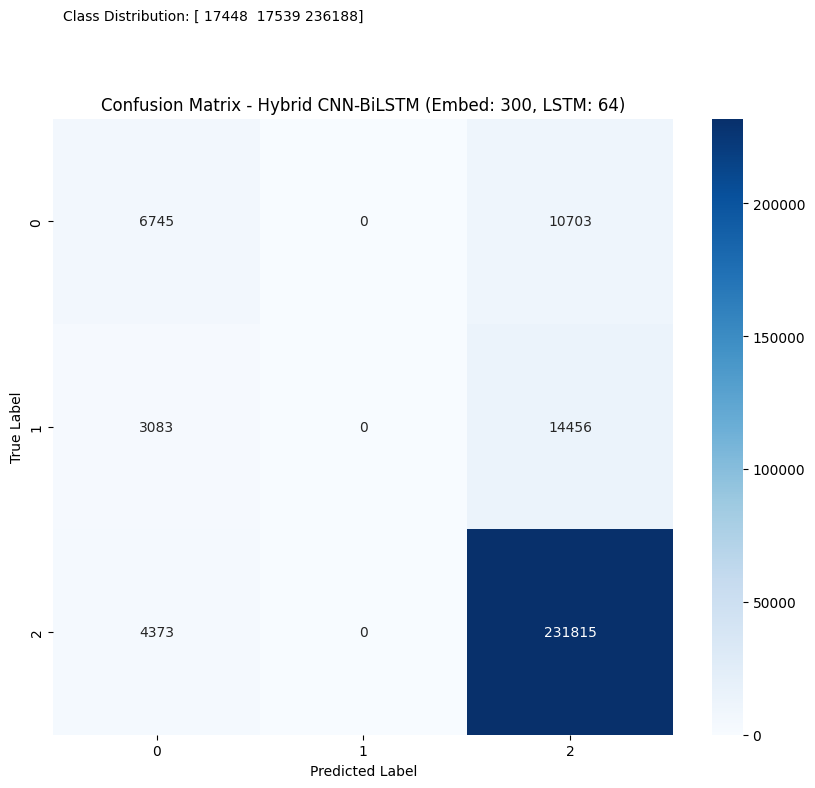

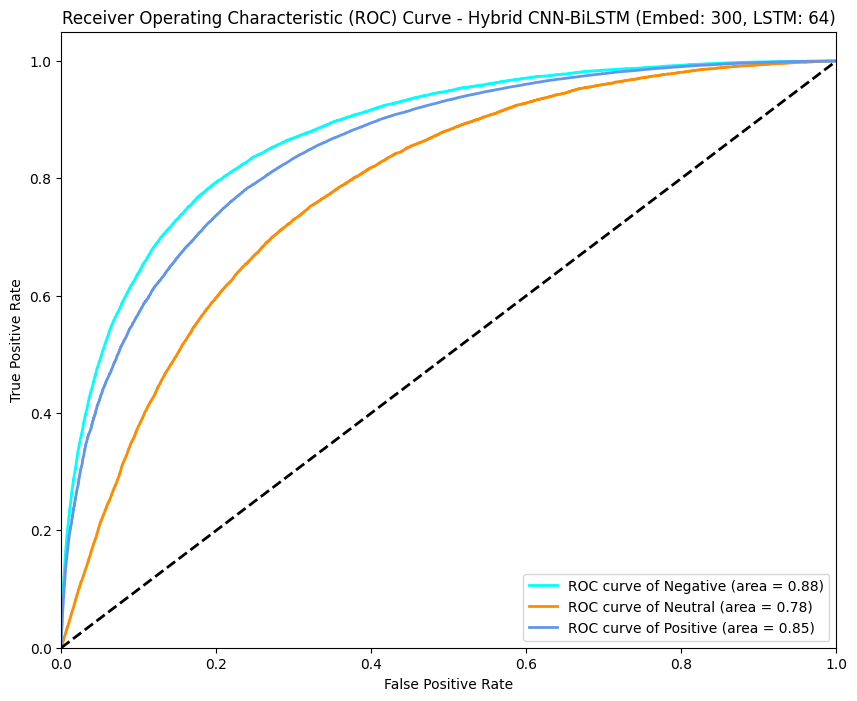


Classification Report - Hybrid CNN-BiLSTM (Embed: 300, LSTM: 64):
              precision    recall  f1-score   support

           0       0.47      0.39      0.43     17448
           1       0.00      0.00      0.00     17539
           2       0.90      0.98      0.94    236188

    accuracy                           0.88    271175
   macro avg       0.46      0.46      0.46    271175
weighted avg       0.82      0.88      0.85    271175



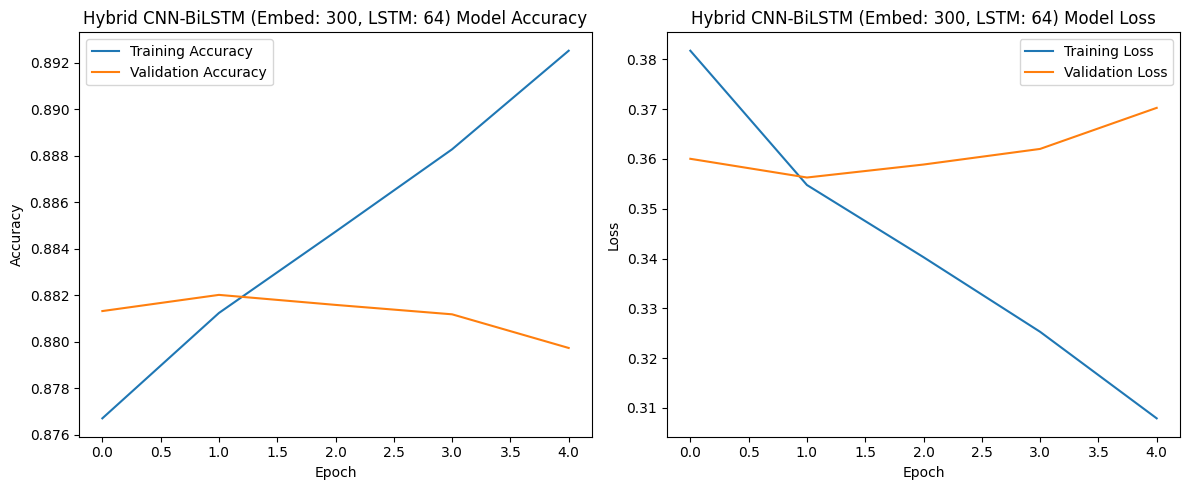


Analysis for Hybrid CNN-BiLSTM (Embed: 300, LSTM: 64):
Class distribution in true labels:
Class 0: 17448
Class 1: 17539
Class 2: 236188

Class distribution in predictions:
Class 0: 14201
Class 2: 256974

Classes not predicted by the model: {1}


In [24]:
def create_and_train_hybrid(embedding_dim, num_words, max_length, lstm_units, X_train, y_train, X_test, y_test, embedding_matrix):
    pipeline_start = time.time()
    num_classes = y_train.shape[1]  # Get the number of classes from y_train

    model_start = time.time()
    # First, define the CNN model
    cnn_model = Sequential([
        Input(shape=(max_length,)),
        Embedding(num_words, embedding_dim, trainable=False, name='embedding'),
        Conv1D(128, 5, activation='relu', name='conv1d'),
        MaxPooling1D(pool_size=4, name='max_pooling1d')
    ])

    # Set the embedding weights for the CNN model
    cnn_model.get_layer('embedding').set_weights([embedding_matrix])

    # Now, add BiLSTM layers sequentially
    hybrid_model = Sequential([
        cnn_model,
        Bidirectional(LSTM(lstm_units, return_sequences=True), name='bilstm_1'),
        Bidirectional(LSTM(lstm_units // 2), name='bilstm_2'),
        Dense(10, activation='relu', name='dense_1'),
        Dropout(0.2, name='dropout'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model_time = time.time() - model_start

    # Train the model and measure training time
    start_time = time.time()
    history = hybrid_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    train_time = time.time() - start_time

    pipeline_time = time.time() - pipeline_start

    return hybrid_model, history, train_time, model_time, pipeline_time

# Create a specific split for Hybrid model
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X, y, test_size=0.3, random_state=42)

# Pad sequences
max_length = 500
X_train_hybrid_padded = pad_sequences(X_train_hybrid, maxlen=max_length)
X_test_hybrid_padded = pad_sequences(X_test_hybrid, maxlen=max_length)

# Convert labels to categorical
num_classes = len(np.unique(y_train_hybrid))
y_train_hybrid_cat = to_categorical(y_train_hybrid, num_classes=num_classes)
y_test_hybrid_cat = to_categorical(y_test_hybrid, num_classes=num_classes)

# Set hyperparameters
lstm_units = best_units # Best from BiLSTM
embedding_dim = best_dim  # Best from CNN
num_words = min(10000, len(word_index) + 1)  # Assuming word_index is defined

# Load GloVe embeddings
embedding_matrix = load_glove_embeddings(word_index, embedding_dim)

print(f"\nTraining Hybrid CNN-BiLSTM with {lstm_units} LSTM units and {embedding_dim}-dimensional embeddings")

model, history, train_time, model_time, pipeline_time = create_and_train_hybrid(embedding_dim, num_words, max_length, lstm_units,
                                                     X_train_hybrid_padded, y_train_hybrid_cat,
                                                     X_test_hybrid_padded, y_test_hybrid_cat,
                                                     embedding_matrix)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_hybrid_padded, y_test_hybrid_cat, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate F1-Score
y_pred = model.predict(X_test_hybrid_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_hybrid_cat, axis=1)
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test_hybrid_cat, y_pred, multi_class='ovr', average='weighted')

# Print results
print("\nHybrid CNN-BiLSTM Results:")
print(f"Embedding Dimensions: {embedding_dim}")
print(f"LSTM Units: {lstm_units}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Model Time: {model_time:.2f} seconds")
print(f"Pipeline Time: {pipeline_time:.2f} seconds")
print(f"Hybrid model summary:")
model.summary()

# Print metrics
print_metrics(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Plot confusion matrix
plot_confusion_matrix(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Plot ROC curve
plot_roc_curve(y_test_hybrid, y_pred, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Print classification report
print(f"\nClassification Report - Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units}):")
print(classification_report(y_test_hybrid, y_pred_classes, zero_division=0))

# Plot training history
plot_training_history(history, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

# Analyze predictions
analyze_predictions(y_test_hybrid, y_pred_classes, f"Hybrid CNN-BiLSTM (Embed: {embedding_dim}, LSTM: {lstm_units})")

hybrid_model = model
y_pred_classes_hybrid = y_pred_classes
y_pred_hybrid = y_pred

# Store results for later comparison
hybrid_results_dict = {
    'model': hybrid_model,
    'embedding_dim': embedding_dim,
    'lstm_units': lstm_units,
    'train_time': train_time,
    'y_true': y_test_hybrid,
    'y_pred': y_pred_classes_hybrid,
    'y_pred_proba': y_pred_hybrid
}

In [25]:
data = bilstm_results_dict
for key, value in data.items():
    print(f"{key}: {value}")

model: <Sequential name=sequential_7, built=True>
lstm_units: 64
accuracy: 0.8835644125938416
y_true: [1 2 2 ... 1 2 2]
y_pred: [0 2 2 ... 0 2 2]
y_pred_proba: [[3.7863854e-01 2.5155461e-01 3.6980692e-01]
 [8.4334047e-04 4.2378032e-03 9.9491888e-01]
 [9.1527095e-03 3.1037174e-02 9.5981014e-01]
 ...
 [5.1365089e-01 2.2059716e-01 2.6575190e-01]
 [3.9042559e-02 5.7335749e-02 9.0362167e-01]
 [7.5211357e-03 2.5151253e-02 9.6732759e-01]]
train_time: 7167.561931848526
model_time: 0.0991981029510498
pipeline_time: 7167.661148309708
prediction_time: 175.61660742759705


# Comparison
This final section provides a comprehensive comparison of all four models:

1. It creates bar plots comparing the accuracy, precision, recall, and F1-score of all models.
1. It prints a table with all metrics for easy comparison.
1. It identifies the best performing model for each metric.
1. Finally, it plots ROC curves for all models on the same graph for direct comparison.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


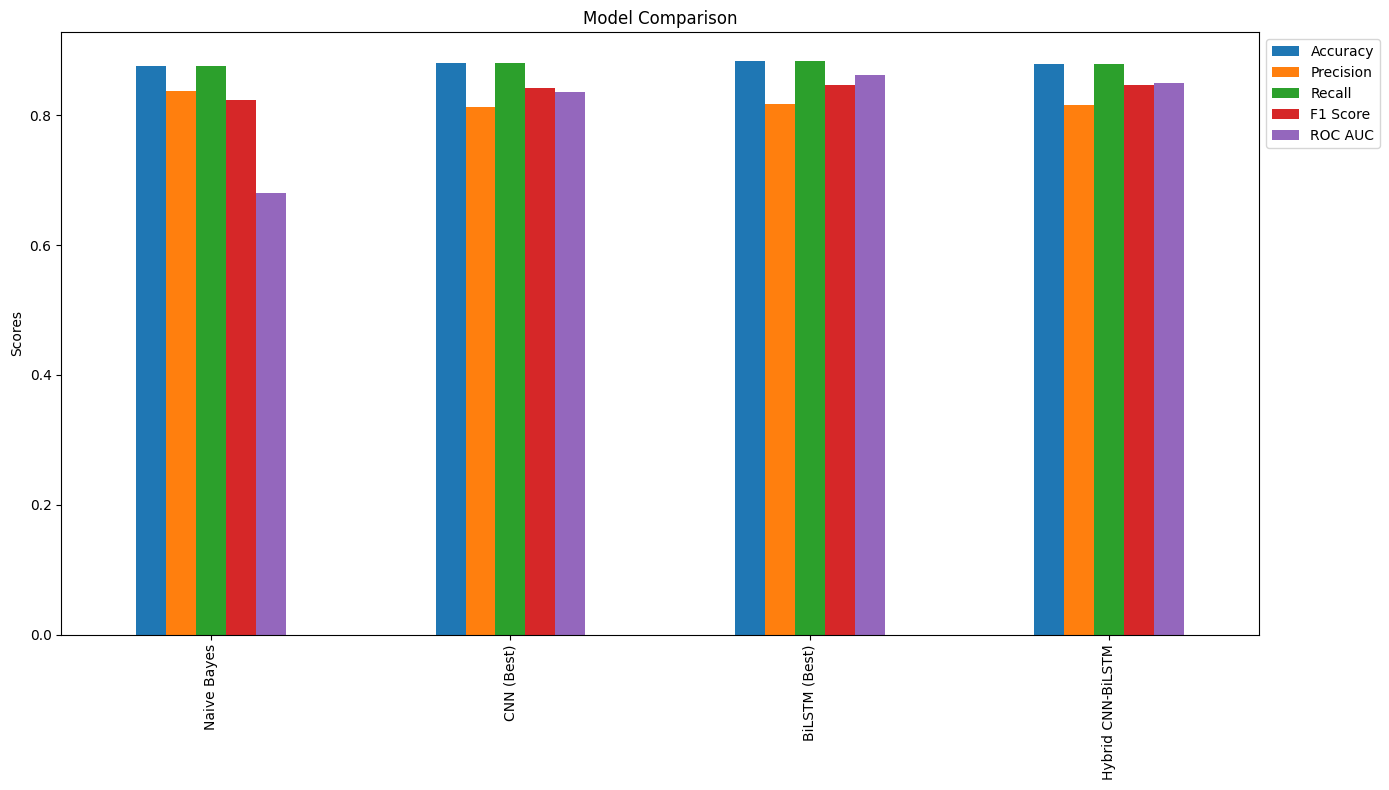


Model Comparison:
                   Accuracy  Precision    Recall  F1 Score   ROC AUC Training Time
Naive Bayes        0.875334   0.837665  0.875334  0.823462  0.679789       0.60 ms
CNN (Best)         0.880841   0.812691  0.880841  0.842180  0.835068      292.93 s
BiLSTM (Best)      0.883564   0.816624  0.883564  0.845883  0.862171     7167.56 s
Hybrid CNN-BiLSTM  0.879727   0.816267  0.879727  0.846248  0.849216     2409.79 s

Best Models:
Best Accuracy: BiLSTM (Best) (0.883564402001956)
Best Precision: Naive Bayes (0.8376648094341761)
Best Recall: BiLSTM (Best) (0.883564402001956)
Best F1 Score: Hybrid CNN-BiLSTM (0.8462482185233333)
Best ROC AUC: BiLSTM (Best) (0.8621712607480636)

Model Configurations:

Naive Bayes:

CNN (Best):
  Embedding Dimension: 300

BiLSTM (Best):
  LSTM Units: 64

Hybrid CNN-BiLSTM:
  Embedding Dimension: 300
  LSTM Units: 64


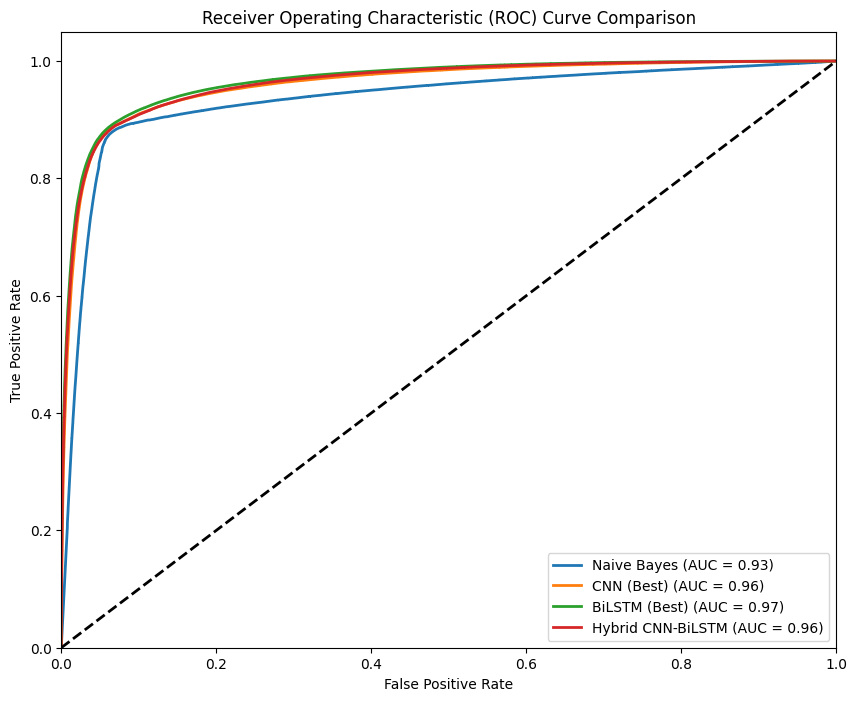

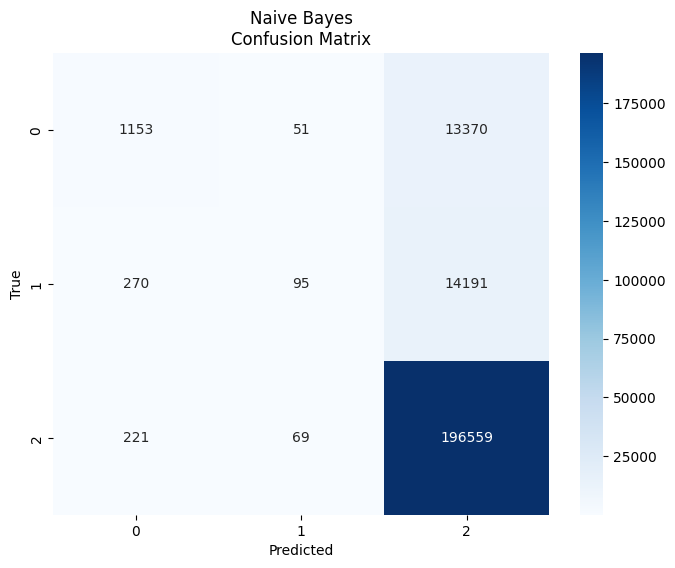

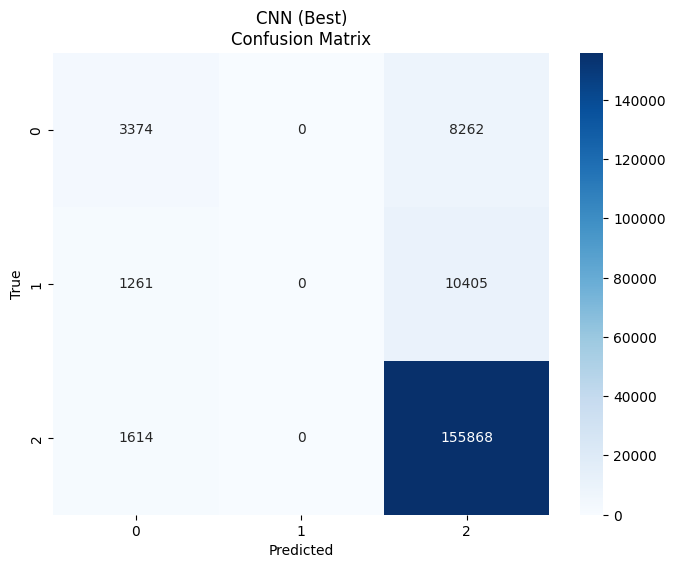

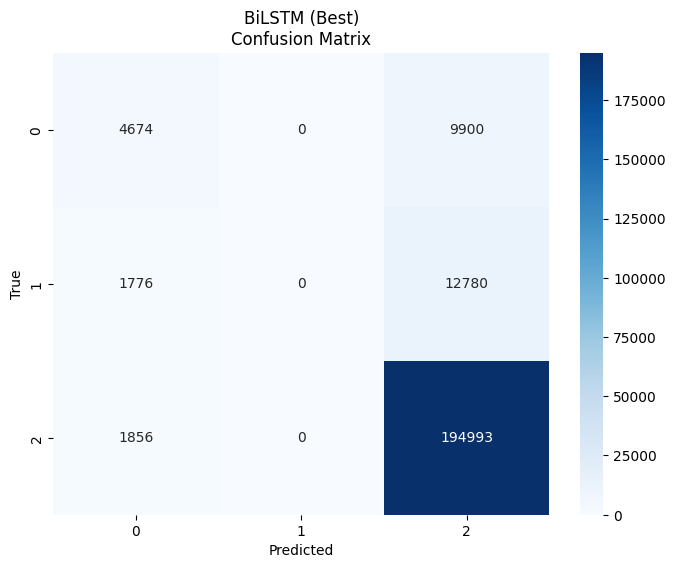

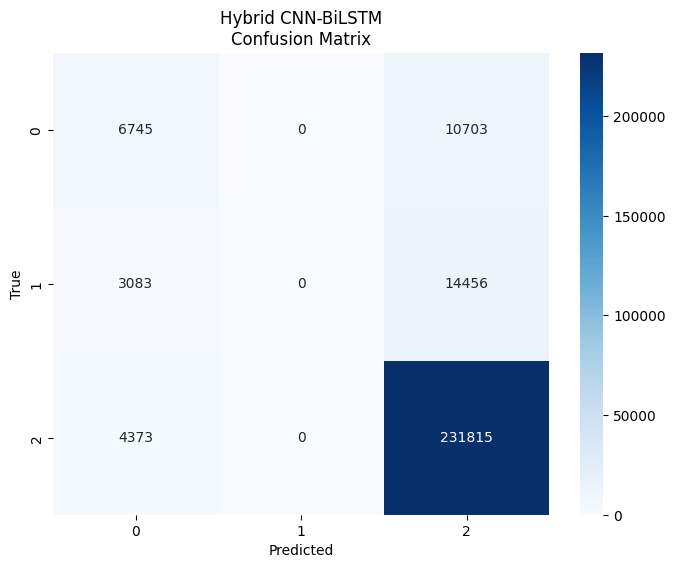

<Figure size 640x480 with 0 Axes>

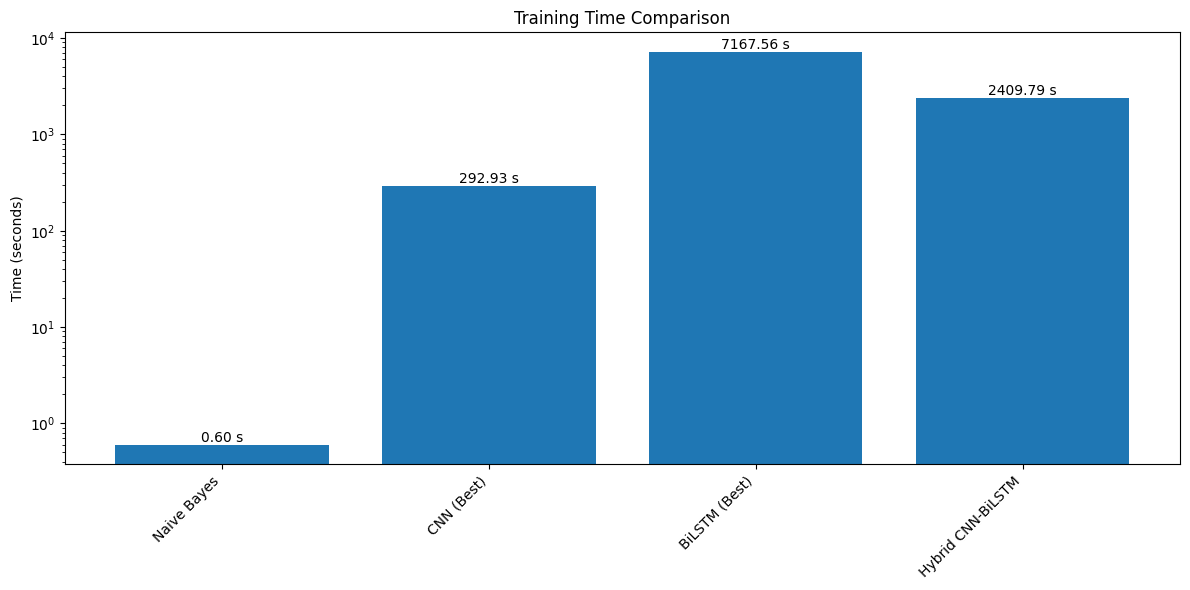

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

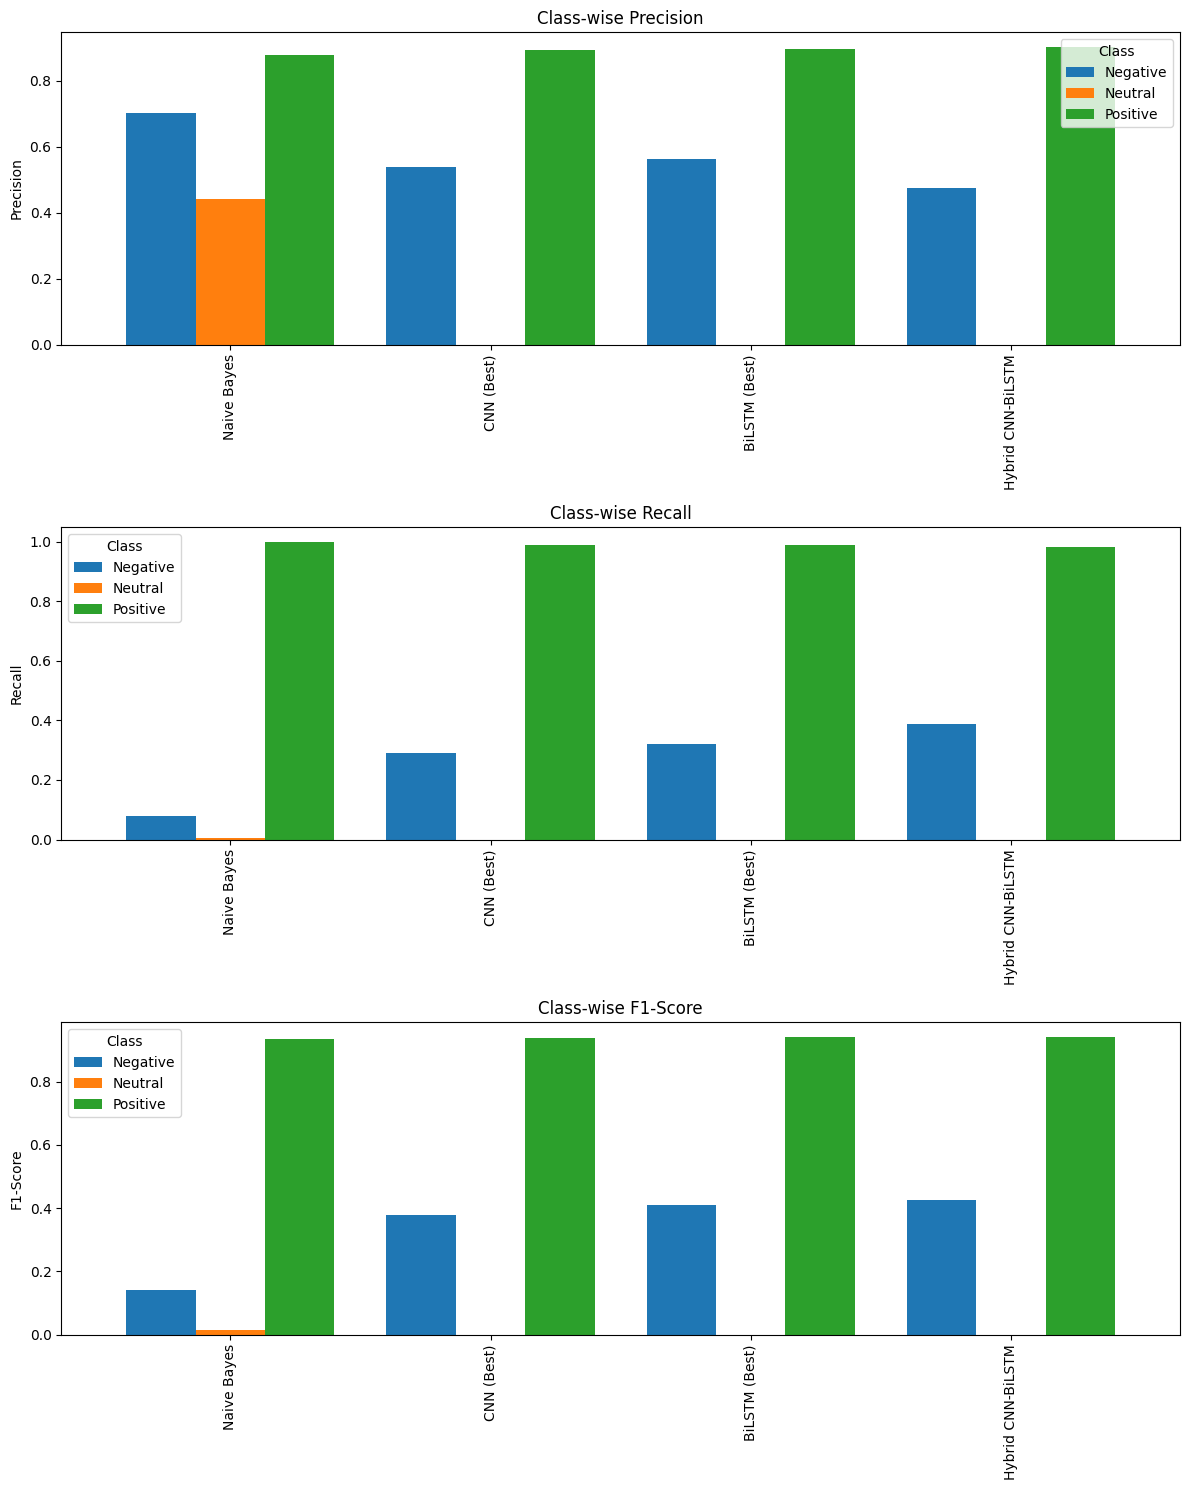

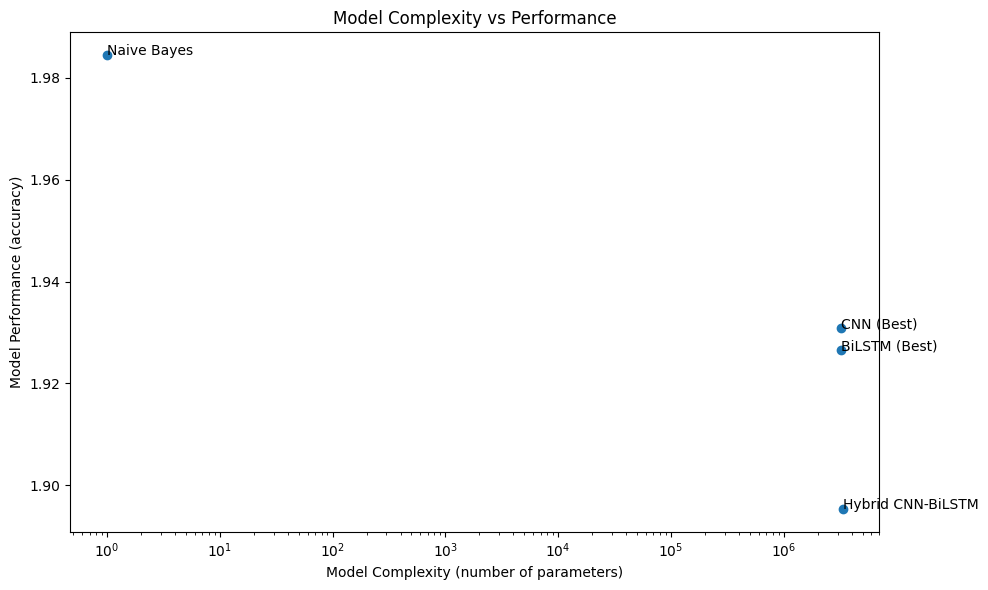


Test Set Sizes:
Naive Bayes: 225979
CNN (Best): 180784
BiLSTM (Best): 225979
Hybrid CNN-BiLSTM: 271175

Class Distribution in Test Sets:

Naive Bayes:
Class 0: 14574 (6.45%)
Class 1: 14556 (6.44%)
Class 2: 196849 (87.11%)

CNN (Best):
Class 0: 11636 (6.44%)
Class 1: 11666 (6.45%)
Class 2: 157482 (87.11%)

BiLSTM (Best):
Class 0: 14574 (6.45%)
Class 1: 14556 (6.44%)
Class 2: 196849 (87.11%)

Hybrid CNN-BiLSTM:
Class 0: 17448 (6.43%)
Class 1: 17539 (6.47%)
Class 2: 236188 (87.10%)

Model Complexity and Configuration Comparison:
Naive Bayes parameters: N/A (not applicable)
CNN parameters: 3193451 (Embedding dim: 300)
BiLSTM parameters: 3228779 (LSTM units: 64)
Hybrid parameters: 3332843 (Embedding dim: 300, LSTM units: 64)


In [26]:
def compare_all_models(models_data):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Training Time']

    results = {}
    for model_name, data in models_data.items():
        y_true = data['y_true']
        y_pred = data['y_pred']
        y_pred_proba = data['y_pred_proba']

        # Handle multiclass ROC AUC
        classes = np.unique(y_true)
        y_true_bin = label_binarize(y_true, classes=classes)
        if len(classes) > 2:
            auc_score = roc_auc_score(y_true_bin, y_pred_proba, multi_class='ovr', average='weighted')
        else:
            auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])

        # Handle training time
        train_time = data.get('train_time', np.nan)
        train_time_str = f"{train_time:.2f} s"

        results[model_name] = [
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, average='weighted'),
            recall_score(y_true, y_pred, average='weighted'),
            f1_score(y_true, y_pred, average='weighted'),
            auc_score,
            train_time_str
        ]

    # Convert results to DataFrame
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=metrics)

    # Plotting performance metrics
    fig, ax = plt.subplots(figsize=(14, 8))
    results_df.iloc[:, :-1].plot(kind='bar', ax=ax)
    ax.set_ylabel('Scores')
    ax.set_title('Model Comparison')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    # Print results
    print("\nModel Comparison:")
    print(results_df.to_string())

    # Determine best model for each metric
    best_models = results_df.iloc[:, :-1].idxmax()  # Exclude 'Training Time' from best model calculation
    print("\nBest Models:")
    for metric, model in best_models.items():
        print(f"Best {metric}: {model} ({results_df.loc[model, metric]})")

    # Print model configurations
    print("\nModel Configurations:")
    for model_name, data in models_data.items():
        print(f"\n{model_name}:")
        if 'embedding_dim' in data:
            print(f"  Embedding Dimension: {data['embedding_dim']}")
        if 'lstm_units' in data:
            print(f"  LSTM Units: {data['lstm_units']}")

    # Plot ROC curves for all models
    plt.figure(figsize=(10, 8))
    for model_name, data in models_data.items():
        y_true = data['y_true']
        y_pred_proba = data['y_pred_proba']

        # Binarize the output
        y_test_bin = label_binarize(y_true, classes=np.unique(y_true))
        n_classes = y_test_bin.shape[1]

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'{model_name} (AUC = {roc_auc["micro"]:.2f})',
                 linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

    return results_df

def plot_confusion_matrices(models_data):
    for model_name, data in models_data.items():
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(data['y_true'], data['y_pred'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name}\nConfusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    plt.tight_layout()
    plt.show()

def plot_training_times(models_data):
    model_names = list(models_data.keys())
    times = [data['train_time'] for model, data in models_data.items()]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(model_names, times)
    plt.title('Training Time Comparison')
    plt.ylabel('Time (seconds)')
    plt.yscale('log')  # Using log scale due to large differences
    plt.xticks(rotation=45, ha='right')

    # Annotate bars with time and units
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                     f'{height:.2f} s',
                     ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.show()

def plot_class_performance(models_data):
    class_names = ['Negative', 'Neutral', 'Positive']  # Adjust based on your classes
    metrics = ['Precision', 'Recall', 'F1-Score']

    fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 5*len(metrics)))
    for i, metric in enumerate(metrics):
        data = []
        for model_name, model_data in models_data.items():
            scores = precision_recall_fscore_support(model_data['y_true'], model_data['y_pred'], average=None)[i]
            data.append(scores)

        df = pd.DataFrame(data, columns=class_names, index=models_data.keys())
        df.plot(kind='bar', ax=axes[i], width=0.8)
        axes[i].set_title(f'Class-wise {metric}')
        axes[i].set_ylabel(metric)
        axes[i].legend(title='Class')

    plt.tight_layout()
    plt.show()

def plot_complexity_vs_performance(models_data):
    complexities = {
        'Naive Bayes': 1,  # placeholder value
        'CNN (Best)': cnn_model.count_params(),
        'BiLSTM (Best)': bilstm_model.count_params(),
        'Hybrid CNN-BiLSTM': hybrid_model.count_params()
    }
    performances = {model: data['y_pred'].mean() for model, data in models_data.items()}

    plt.figure(figsize=(10, 6))
    plt.scatter(complexities.values(), performances.values())
    for model, complexity in complexities.items():
        plt.annotate(model, (complexity, performances[model]))
    plt.xscale('log')
    plt.xlabel('Model Complexity (number of parameters)')
    plt.ylabel('Model Performance (accuracy)')
    plt.title('Model Complexity vs Performance')
    plt.tight_layout()
    plt.show()

# Prepare data for comparison
models_data = {
    'Naive Bayes': nb_results_dict,
    'CNN (Best)': cnn_results_dict,
    'BiLSTM (Best)': bilstm_results_dict,
    'Hybrid CNN-BiLSTM': hybrid_results_dict
}

# Run comparison
results_df = compare_all_models(models_data)
plot_confusion_matrices(models_data)
plot_training_times(models_data)
plot_class_performance(models_data)
plot_complexity_vs_performance(models_data)

# Additional analysis
print("\nTest Set Sizes:")
for model, data in models_data.items():
    print(f"{model}: {len(data['y_true'])}")

print("\nClass Distribution in Test Sets:")
for model, data in models_data.items():
    y_test = data['y_true']
    unique, counts = np.unique(y_test, return_counts=True)
    print(f"\n{model}:")
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} ({count/len(y_test):.2%})")



# Model complexity and configuration comparison
print("\nModel Complexity and Configuration Comparison:")
print(f"Naive Bayes parameters: N/A (not applicable)")
print(f"CNN parameters: {cnn_model.count_params()} (Embedding dim: {models_data['CNN (Best)']['embedding_dim']})")
print(f"BiLSTM parameters: {bilstm_model.count_params()} (LSTM units: {models_data['BiLSTM (Best)']['lstm_units']})")
print(f"Hybrid parameters: {hybrid_model.count_params()} (Embedding dim: {models_data['Hybrid CNN-BiLSTM']['embedding_dim']}, LSTM units: {models_data['Hybrid CNN-BiLSTM']['lstm_units']})")

In [30]:
import pickle
# Save models and results
def save_models_and_results(models_dict, filename_prefix):
    # Save each model separately (because they might be large)
    for model_name, results in models_dict.items():
        # Save the model
        model = results['model']
        model.save(f'{filename_prefix}_{model_name.lower()}_model.keras')

        # Create a copy of results without the model
        results_copy = results.copy()
        results_copy.pop('model')  # Remove model from dictionary before saving

        # Save other results
        with open(f'{filename_prefix}_{model_name.lower()}_results.pkl', 'wb') as f:
            pickle.dump(results_copy, f)




models_to_save_dict = {
    'CNN (Best)': cnn_results_dict,
    'BiLSTM (Best)': bilstm_results_dict,
    'Hybrid CNN-BiLSTM': hybrid_results_dict
}

# Modified save function for Naive Bayes
import joblib

# Save Naive Bayes model
joblib.dump(nb_results_dict['model'], 'nb_model_bgg.joblib')

save_models_and_results(models_to_save_dict, 'sentiment_analysis_bgg')

In [ ]:
# To load later:
# To load the models and results back
def load_models_and_results(models_list, filename_prefix):
    from keras_core.models import load_model

    loaded_models = {}
    for model_name in models_list:
        # Load the model
        model = load_model(f'{filename_prefix}_{model_name.lower()}_model')

        # Load the results
        with open(f'{filename_prefix}_{model_name.lower()}_results.pkl', 'rb') as f:
            results = pickle.load(f)

        # Combine model and results
        results['model'] = model
        loaded_models[model_name] = results

    return loaded_models

models_list = ['CNN (Best)', 'BiLSTM (Best)', 'Hybrid CNN-BiLSTM']
loaded_models = load_models_and_results(models_list, 'sentiment_analysis_bgg')
nb_results_dict = joblib.load('nb_model_bgg.joblib')